# Import the drive since the dataset is stored there

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Import all the relevant packages

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import nibabel as nib
import numpy as np

# Set device for CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Build the dataset class

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing subject folders.
            transform (callable, optional): Transformation to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Assumes folder names like 'BraTS-GLI-00000-000', etc.
        self.subject_dirs = sorted([
            os.path.join(root_dir, d)
            for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])

    def __len__(self):
        return len(self.subject_dirs)

    def __getitem__(self, idx):
        sub_dir = self.subject_dirs[idx]
        files = os.listdir(sub_dir)
        # Find the necessary files by modality identifier
        seg_file  = [f for f in files if 'seg.nii.gz' in f][0]
        t1c_file  = [f for f in files if 't1c.nii.gz' in f][0]
        t1n_file  = [f for f in files if 't1n.nii.gz' in f][0]
        t2f_file  = [f for f in files if 't2f.nii.gz' in f][0]
        t2w_file  = [f for f in files if 't2w.nii.gz' in f][0]

        # Load images using nibabel
        seg  = nib.load(os.path.join(sub_dir, seg_file)).get_fdata()
        t1c  = nib.load(os.path.join(sub_dir, t1c_file)).get_fdata()
        t1n  = nib.load(os.path.join(sub_dir, t1n_file)).get_fdata()
        t2f  = nib.load(os.path.join(sub_dir, t2f_file)).get_fdata()
        t2w  = nib.load(os.path.join(sub_dir, t2w_file)).get_fdata()

        # Stack modalities into a (C, H, W, D) volume (channels: t1c, t1n, t2f, t2w)
        image = np.stack([t1c, t1n, t2f, t2w], axis=0).astype(np.float32)

        # Per-channel z-score normalization
        for i in range(image.shape[0]):
            mean = np.mean(image[i])
            std = np.std(image[i]) if np.std(image[i]) > 0 else 1.0
            image[i] = (image[i] - mean) / std

        seg = seg.astype(np.int64)

        if self.transform:
            image, seg = self.transform(image, seg)

        return {'image': torch.tensor(image), 'label': torch.tensor(seg)}


# Get the dataset splits and the dataloaders

In [ ]:
# Set the dataset path (modify to your location)
dataset_path = '/content/drive/MyDrive/BraTS2025-GLI-PRE-Challenge-TrainingData'

# Create the full dataset (full-volume each sample)
full_dataset = BraTSDataset(dataset_path)

# Choose a subset percentage (e.g., using 20% of the data)
subset_percent = 0.35
subset_length = int(len(full_dataset) * subset_percent)
print(f"Using subset of {subset_length} samples out of {len(full_dataset)} total subjects.")

# Create a subset
subset_indices = list(range(subset_length))
subset_dataset = Subset(full_dataset, subset_indices)

# Now split the subset into train/validation/test splits (80/10/10 split)
total_samples = len(subset_dataset)
train_len = int(0.6 * total_samples)
val_len   = int(0.2 * total_samples)
test_len  = total_samples - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_len, val_len, test_len])
print(f"Train/Val/Test split (subset): {train_len} / {val_len} / {test_len} samples.")

# Create DataLoaders with a small batch size (adjust num_workers if needed)
batch_size = 1  # You can increase if memory permits
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Using subset of 437 samples out of 1251 total subjects.
Train/Val/Test split (subset): 262 / 87 / 88 samples.


# Define the helper functions and loss functions

In [ ]:
def center_crop_target(label, target_shape):
    """
    Center-crop a 4D tensor (B, H, W, D) to target spatial shape (target_H, target_W, target_D).
    """
    B, H, W, D = label.shape
    target_H, target_W, target_D = target_shape
    start_H = (H - target_H) // 2
    start_W = (W - target_W) // 2
    start_D = (D - target_D) // 2
    return label[:, start_H:start_H+target_H, start_W:start_W+target_W, start_D:start_D+target_D]

def dice_loss(pred, target, smooth=1e-5):
    pred = torch.softmax(pred, dim=1)
    target_onehot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])
    target_onehot = target_onehot.permute(0, 4, 1, 2, 3).float()
    intersection = (pred * target_onehot).sum(dim=(2,3,4))
    union = pred.sum(dim=(2,3,4)) + target_onehot.sum(dim=(2,3,4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    if pred.shape[2:] != target.shape[1:]:
        target = center_crop_target(target, pred.shape[2:])
    ce_loss = nn.CrossEntropyLoss()(pred, target)
    d_loss = dice_loss(pred, target)
    return ce_loss + d_loss


# Define the train and validation function

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, optimizer, device):
    model.to(device)
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for i, batch in enumerate(train_loader, start=1):
            images = batch['image'].to(device)  # (B, C, H, W, D)
            labels = batch['label'].to(device)    # (B, H, W, D)
            optimizer.zero_grad()

            outputs = model(images)
            loss = combined_loss(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(f"  Iteration {i}/{len(train_loader)}: Loss = {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader)

        # Validation phase: compute validation loss over the entire val_loader
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                outputs = model(images)
                loss = combined_loss(outputs, labels)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader)

        print(f"Epoch {epoch+1} Training Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")

        # Save best model weights based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    return model


# Build the model architecture (class)

In [ ]:

def center_crop(tensor, target_shape):
    _, _, h, w, d = tensor.shape
    target_h, target_w, target_d = target_shape
    start_h = (h - target_h) // 2
    start_w = (w - target_w) // 2
    start_d = (d - target_d) // 2
    return tensor[:, :,
                  start_h:start_h+target_h,
                  start_w:start_w+target_w,
                  start_d:start_d+target_d]

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        branch_channels = out_channels // 4
        self.branch1 = nn.Conv3d(in_channels, branch_channels, kernel_size=1, padding=0)
        self.branch2 = nn.Conv3d(in_channels, branch_channels, kernel_size=3, padding=1)
        self.branch3 = nn.Conv3d(in_channels, branch_channels, kernel_size=5, padding=2)
        self.branch4 = nn.Conv3d(in_channels, branch_channels, kernel_size=7, padding=3)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.relu(out)

class InceptionUNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=32):
        super(InceptionUNet, self).__init__()
        # Encoder
        self.encoder1 = InceptionBlock(in_channels, features)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = InceptionBlock(features, features*2)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = InceptionBlock(features*2, features*4)
        self.pool3 = nn.MaxPool3d(2)
        # Bottleneck
        self.bottleneck = InceptionBlock(features*4, features*8)
        # Decoder
        self.up3 = nn.ConvTranspose3d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = InceptionBlock(features*8, features*4)
        self.up2 = nn.ConvTranspose3d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = InceptionBlock(features*4, features*2)
        self.up1 = nn.ConvTranspose3d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = InceptionBlock(features*2, features)
        self.conv_last = nn.Conv3d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        bottleneck = self.bottleneck(self.pool3(enc3))

        dec3 = self.up3(bottleneck)
        if enc3.shape[2:] != dec3.shape[2:]:
            enc3 = center_crop(enc3, dec3.shape[2:])
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.up2(dec3)
        if enc2.shape[2:] != dec2.shape[2:]:
            enc2 = center_crop(enc2, dec2.shape[2:])
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.up1(dec2)
        if enc1.shape[2:] != dec1.shape[2:]:
            enc1 = center_crop(enc1, dec1.shape[2:])
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv_last(dec1)

# Create an instance of the model and start training

In [ ]:
# Set model parameters
num_classes = 4   # Adjust based on your segmentation labels.
in_channels = 4   # (t1c, t1n, t2f, t2w).
features = 32     # Change if needed.

model_incep = InceptionUNet(in_channels, num_classes, features=features)
optimizer_incep = optim.Adam(model_incep.parameters(), lr=1e-4)
num_epochs = 2   # Adjust for your needs.

print("Training Inception U-Net on a subset (full volume) with iteration-level logging...")
model_incep = train_model(model_incep, train_loader, val_loader, num_epochs, optimizer_incep, device)

Training Inception U-Net on a subset (full volume) with iteration-level logging...

Epoch 1/2
  Iteration 1/262: Loss = 2.2438
  Iteration 2/262: Loss = 2.1085
  Iteration 3/262: Loss = 1.9971
  Iteration 4/262: Loss = 1.8784
  Iteration 5/262: Loss = 1.7337
  Iteration 6/262: Loss = 1.5369
  Iteration 7/262: Loss = 1.3141
  Iteration 8/262: Loss = 1.0720
  Iteration 9/262: Loss = 0.9548
  Iteration 10/262: Loss = 0.9167
  Iteration 11/262: Loss = 0.8086
  Iteration 12/262: Loss = 1.0732
  Iteration 13/262: Loss = 1.0616
  Iteration 14/262: Loss = 1.3794
  Iteration 15/262: Loss = 0.8000
  Iteration 16/262: Loss = 0.9740
  Iteration 17/262: Loss = 0.8646
  Iteration 18/262: Loss = 0.8783
  Iteration 19/262: Loss = 0.7795
  Iteration 20/262: Loss = 0.8312
  Iteration 21/262: Loss = 0.8036
  Iteration 22/262: Loss = 0.8016
  Iteration 23/262: Loss = 0.8114
  Iteration 24/262: Loss = 0.8576
  Iteration 25/262: Loss = 0.8220
  Iteration 26/262: Loss = 0.8176
  Iteration 27/262: Loss = 0.82

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            loss = combined_loss(outputs, labels)
            total_loss += loss.item() * images.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    print("Test Loss: {:.4f}".format(avg_loss))

print("Evaluating Inception U-Net on Test Set")
evaluate_model(model_incep, test_loader, device)


# Visualize the predicted masks

In [ ]:
import matplotlib.pyplot as plt

def show_examples(model, data_loader, num_examples=5):
    """5
    Displays num_examples from the data_loader as:
      - Original image (first modality, e.g. T1c),
      - Predicted segmentation,
      - Ground truth segmentation.

    Assumes that:
      - The model expects input shape (B, C, H, W, D)
      - Ground truth labels are of shape (B, H, W, D)
      - We use the middle slice along the depth dimension for visualization.
    """
    model.eval()
    examples_shown = 0
    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)  # shape: (B, C, H, W, D)
            labels = batch['label'].to(device)    # shape: (B, H, W, D)

            # Inference
            outputs = model(images)             # shape: (B, num_classes, H, W, D)
            preds = torch.argmax(outputs, dim=1)  # shape: (B, H, W, D)

            # Select the first (and only, since batch_size=1) sample
            image_np = images.cpu().numpy()[0]    # shape: (C, H, W, D)
            label_np = labels.cpu().numpy()[0]      # shape: (H, W, D)
            pred_np  = preds.cpu().numpy()[0]       # shape: (H, W, D)

            # Choose the middle slice along the depth axis (D dimension)
            depth = image_np.shape[3]
            slice_idx = depth // 2

            # Select one modality from the original image (e.g., channel 0, which might be T1c)
            original_slice = image_np[0, :, :, slice_idx]
            pred_slice     = pred_np[:, :, slice_idx]
            label_slice    = label_np[:, :, slice_idx]

            # Create a figure to display all three images side by side
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(original_slice, cmap='gray')
            axes[0].set_title("Original (Channel 0)")
            axes[0].axis('off')

            axes[1].imshow(pred_slice, cmap='jet')
            axes[1].set_title("Predicted Segmentation")
            axes[1].axis('off')

            axes[2].imshow(label_slice, cmap='jet')
            axes[2].set_title("Ground Truth Segmentation")
            axes[2].axis('off')

            plt.show()

            examples_shown += 1
            if examples_shown >= num_examples:
                break


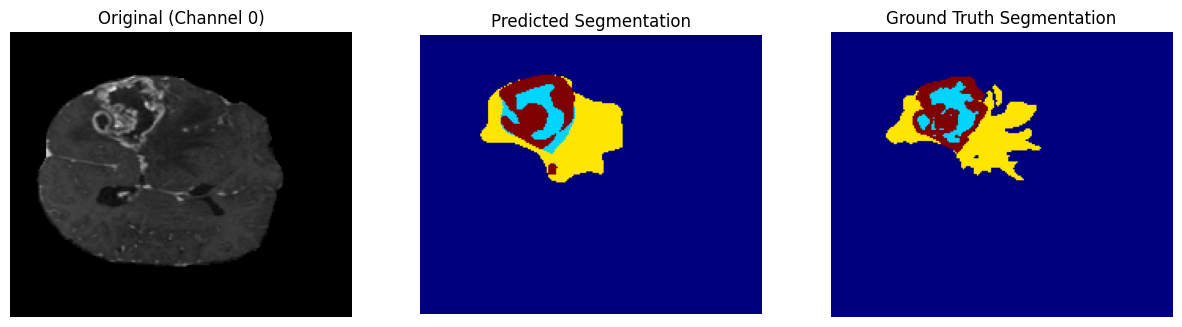

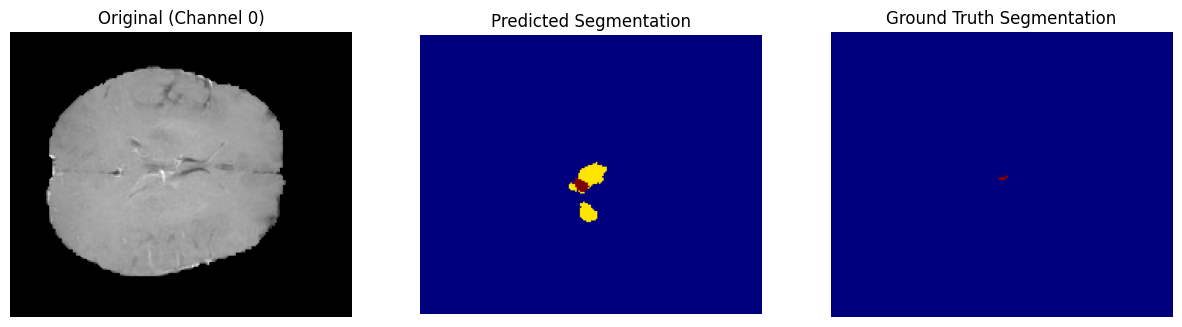

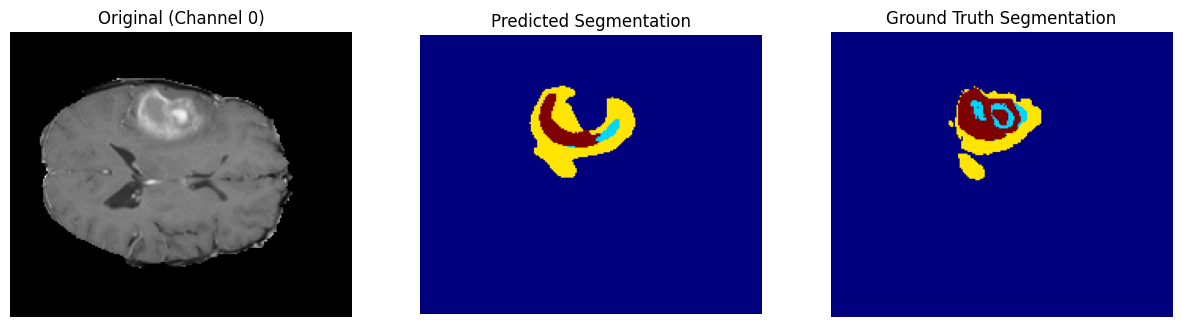

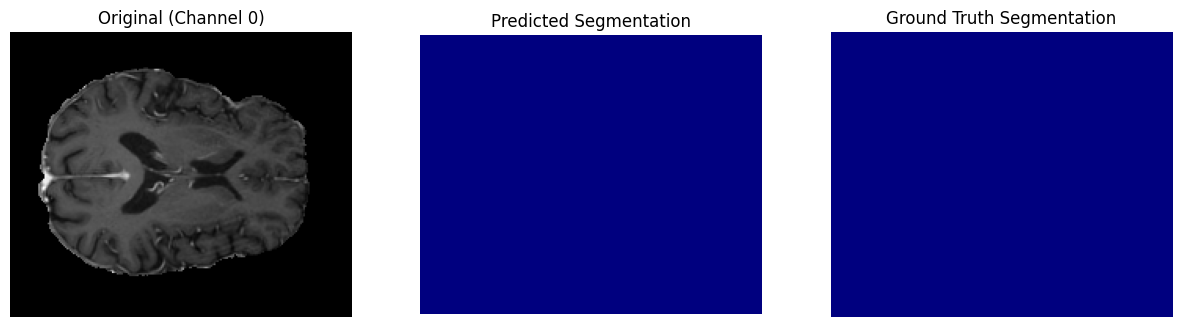

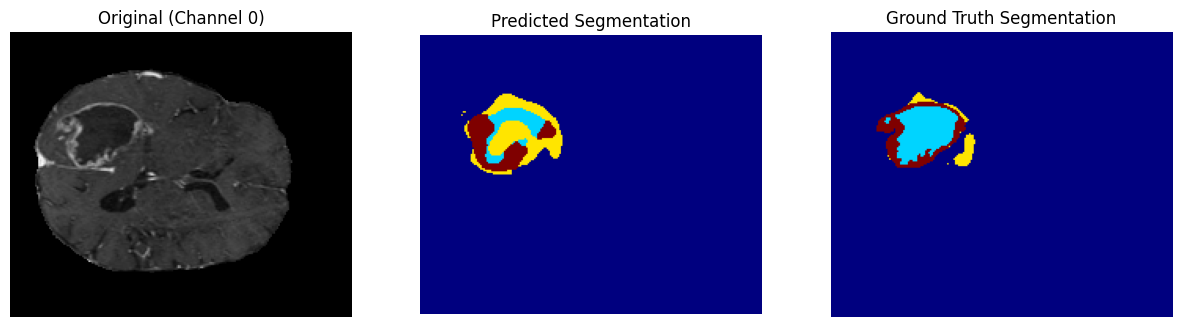

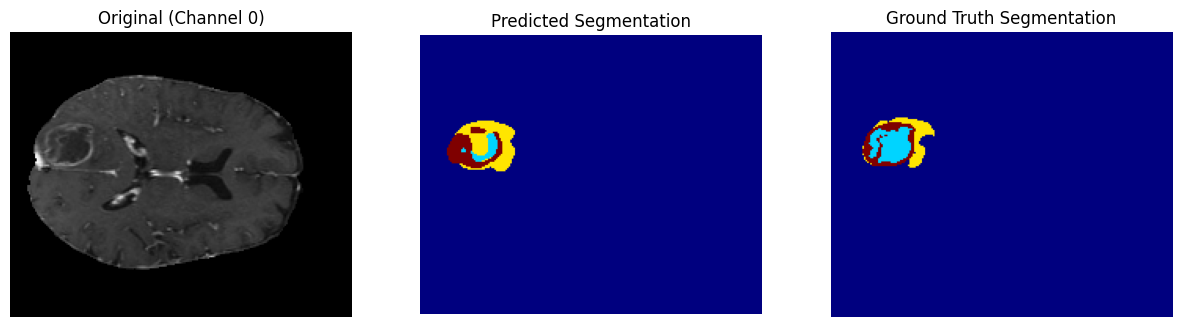

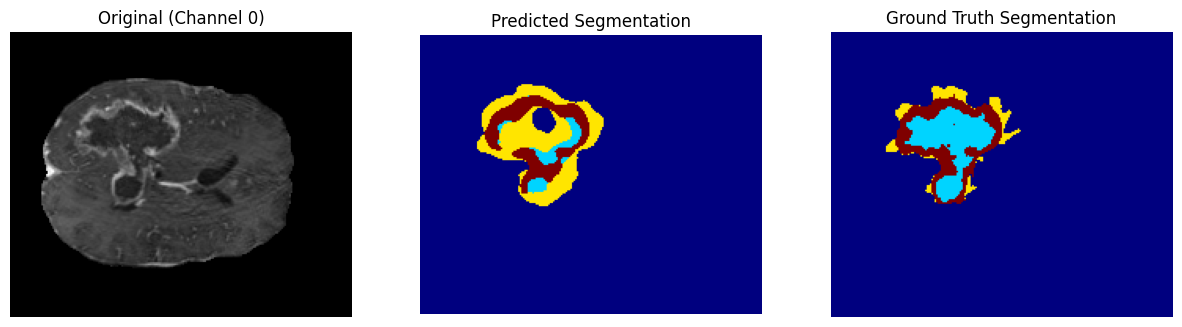

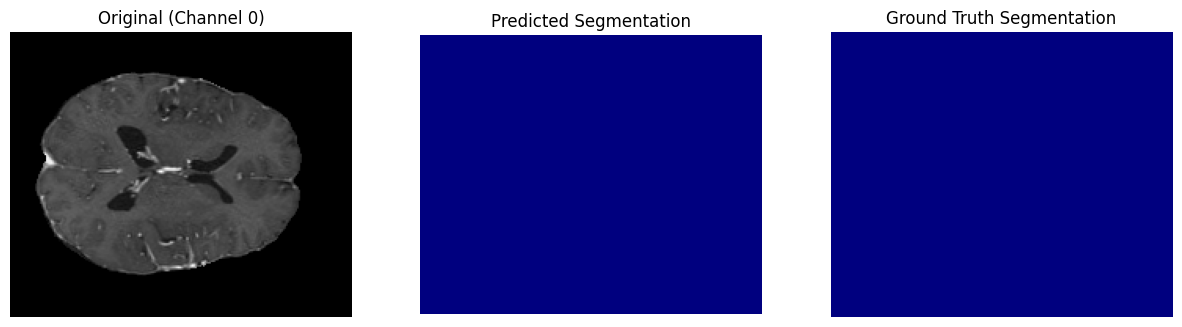

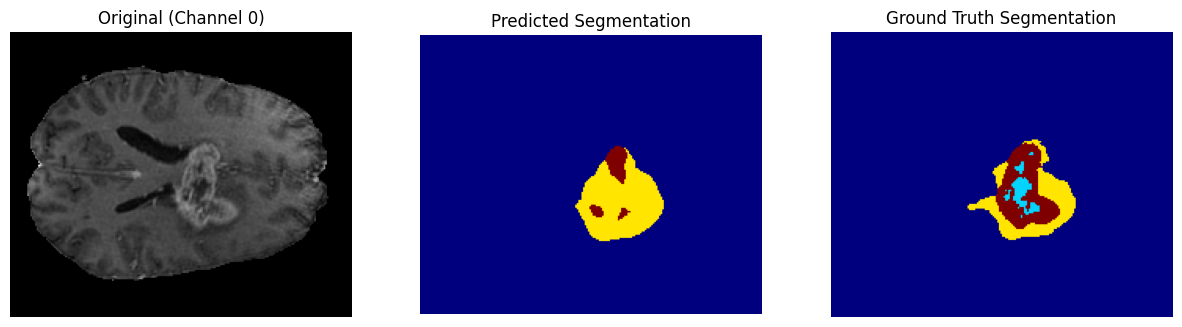

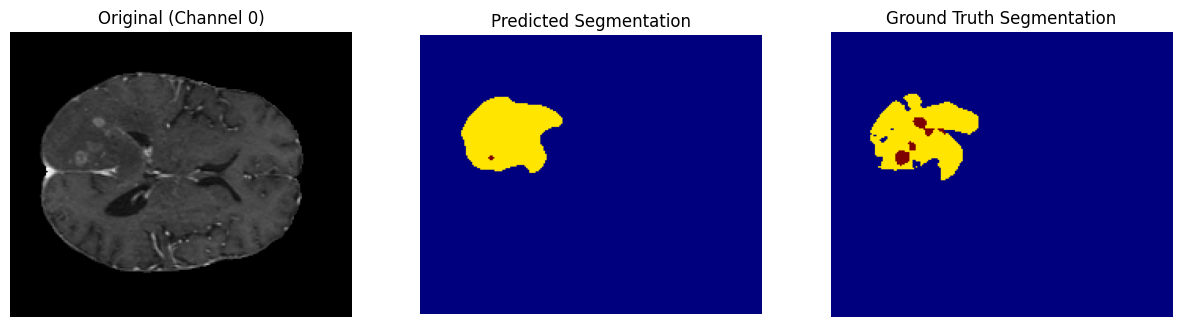

In [ ]:
# Example usage: Display 5 examples from the test set
show_examples(model_incep, test_loader, num_examples= 10)

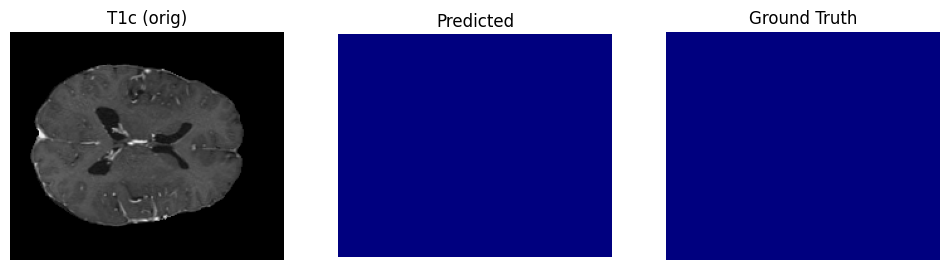

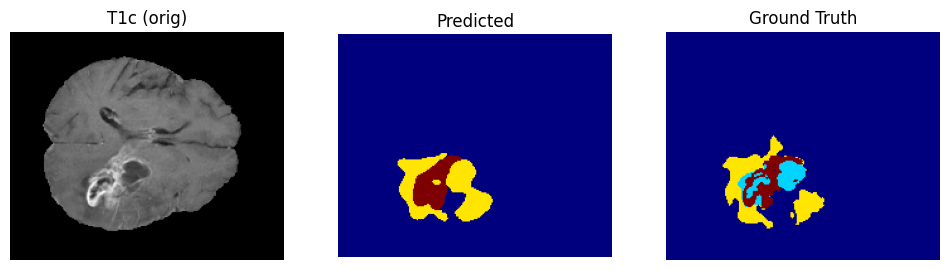

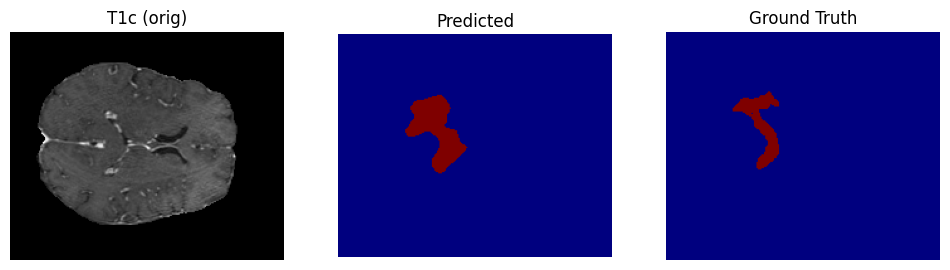

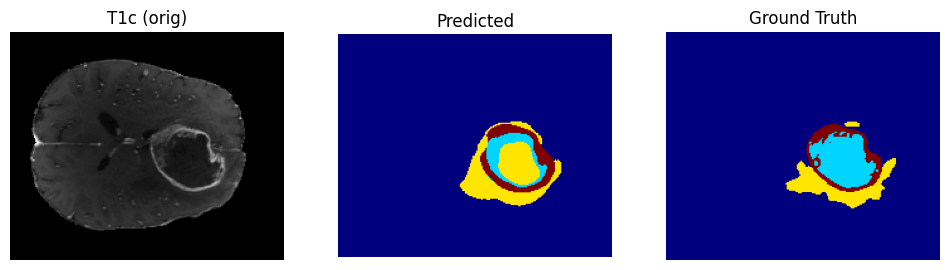

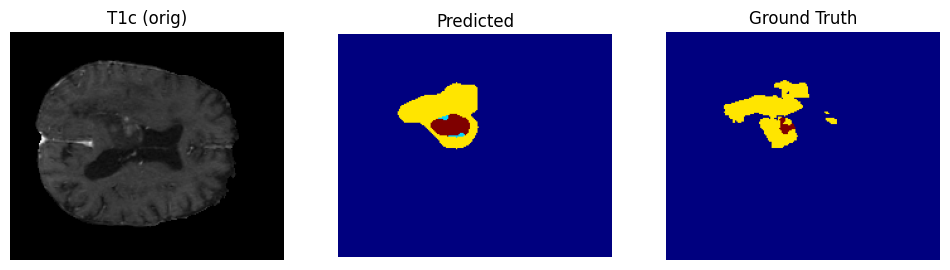

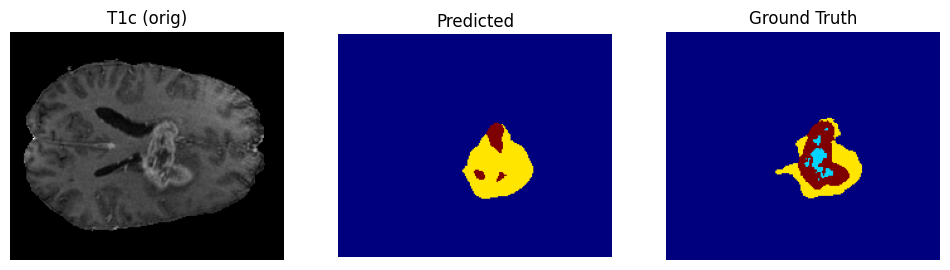

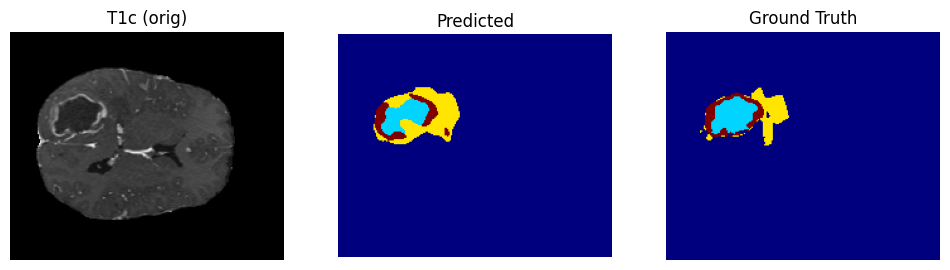

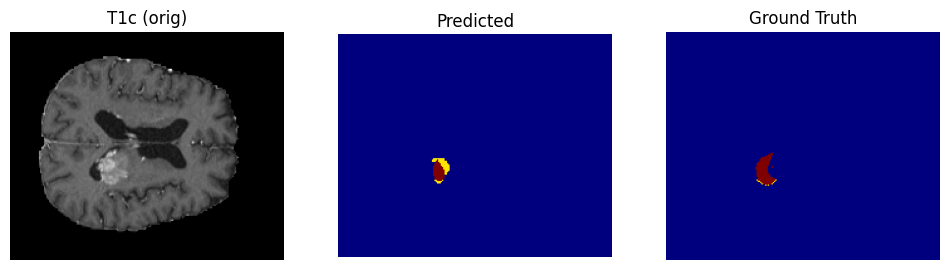

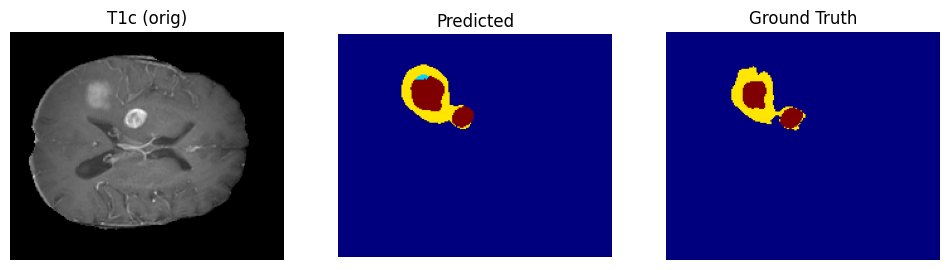

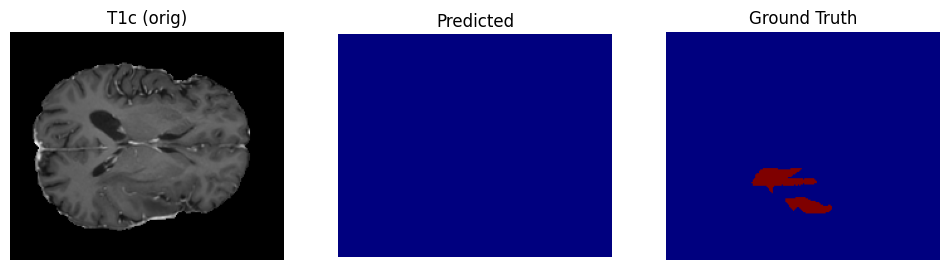

In [ ]:
# Cell: Visualize 5 Random Test Samples with Predictions and Ground Truth

import random
import matplotlib.pyplot as plt

model_incep.eval()
# sample 5 random indices from test_dataset
indices = random.sample(range(len(test_dataset)), 10)

for idx in indices:
    sample = test_dataset[idx]
    image, label = sample['image'], sample['label']
    # run inference
    with torch.no_grad():
        out = model_incep(image.unsqueeze(0).to(device))
        pred = out.argmax(dim=1).cpu().squeeze(0).numpy()      # (H,W,D)
    img_np   = image.cpu().numpy()                            # (C,H,W,D)
    label_np = label.cpu().numpy()                            # (H,W,D)
    d_mid    = img_np.shape[3] // 2                           # middle depth slice

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img_np[0, :, :, d_mid], cmap='gray')
    axes[0].set_title("T1c (orig)");     axes[0].axis('off')
    axes[1].imshow(pred[:, :, d_mid],   cmap='jet')
    axes[1].set_title("Predicted");     axes[1].axis('off')
    axes[2].imshow(label_np[:, :, d_mid], cmap='jet')
    axes[2].set_title("Ground Truth");  axes[2].axis('off')
    plt.show()

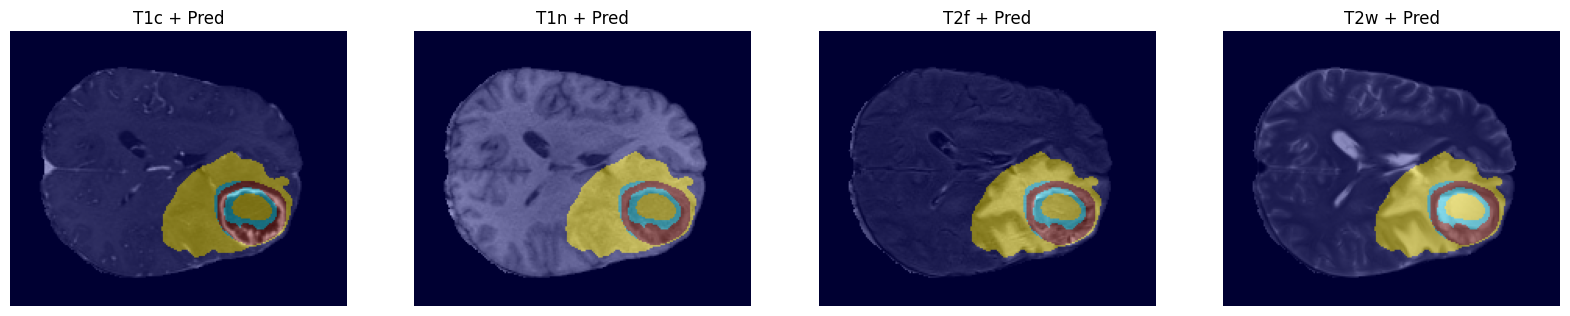

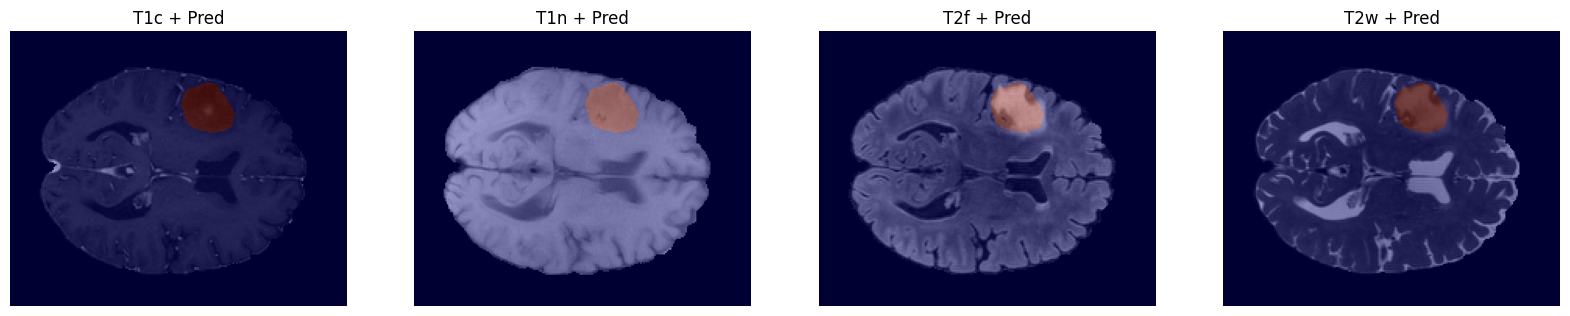

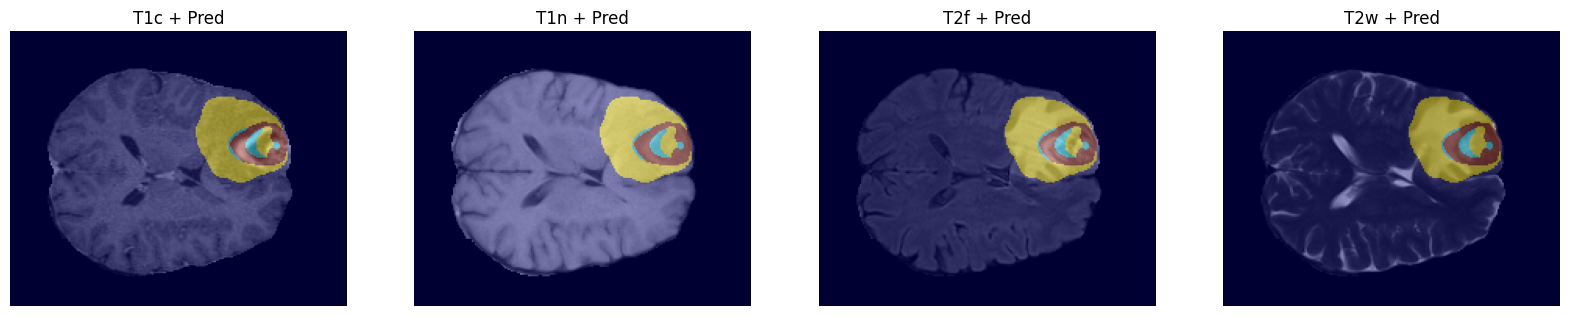

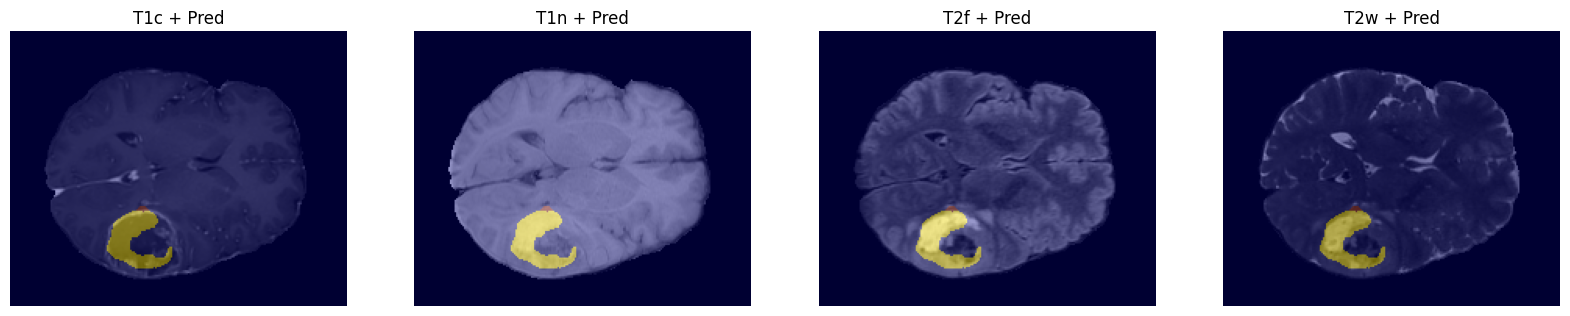

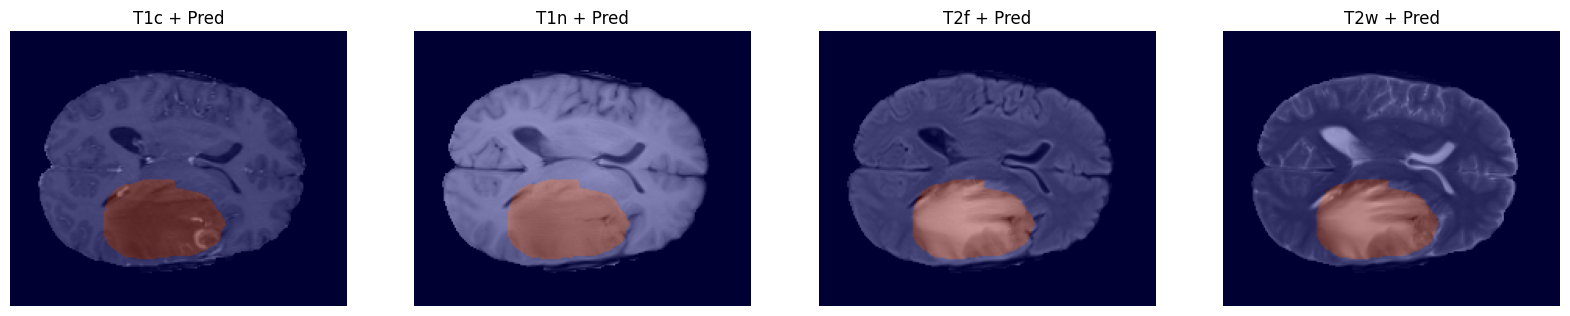

In [ ]:
# Cell: Visualize 5 Random Test Samples — All 4 Modalities with Predicted Overlay

import random
import matplotlib.pyplot as plt

model_incep.eval()
indices = random.sample(range(len(test_dataset)), 5)

for idx in indices:
    sample = test_dataset[idx]
    image, label = sample['image'], sample['label']
    # Inference
    with torch.no_grad():
        out  = model_incep(image.unsqueeze(0).to(device))
        pred = out.argmax(dim=1).cpu().squeeze(0).numpy()  # (H, W, D)

    # Convert to numpy
    mods   = image.cpu().numpy()   # (4, H, W, D)
    slice_ = mods.shape[3] // 2    # middle depth index

    # Plot each modality with segmentation overlay
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    modality_names = ['T1c', 'T1n', 'T2f', 'T2w']
    for m, ax in enumerate(axes):
        img_slice = mods[m, :, :, slice_]
        ax.imshow(img_slice, cmap='gray')
        ax.imshow(pred[:, :, slice_], cmap='jet', alpha=0.4)
        ax.set_title(f"{modality_names[m]} + Pred")
        ax.axis('off')
    plt.show()

In [ ]:
import numpy as np

def evaluate_iou_accuracy(model, test_loader, device):
    """
    Computes per‐sample mean IoU (averaged across classes) and pixel accuracy over the test set.
    Returns lists of IoU and accuracy values for each sample.
    """
    model.to(device)
    model.eval()
    iou_list = []
    acc_list = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)        # (B, C, H, W, D)
            labels = batch['label'].to(device)        # (B, H, W, D)
            outputs = model(images)                   # (B, num_classes, H_out, W_out, D_out)
            preds = outputs.argmax(dim=1)             # (B, H_out, W_out, D_out)

            # Crop labels if spatial sizes mismatch
            if preds.shape[1:] != labels.shape[1:]:
                labels = center_crop_target(labels, preds.shape[1:])

            B, *_ = preds.shape
            num_classes = outputs.shape[1]

            for b in range(B):
                pred = preds[b]
                label = labels[b]

                # Compute IoU per class and then mean IoU
                iou_per_class = []
                for cls in range(num_classes):
                    pred_i   = (pred == cls)
                    label_i  = (label == cls)
                    inter    = torch.logical_and(pred_i, label_i).sum().item()
                    union    = torch.logical_or(pred_i, label_i).sum().item()
                    iou      = inter / union if union > 0 else np.nan
                    iou_per_class.append(iou)

                mean_iou = np.nanmean(iou_per_class)
                iou_list.append(mean_iou)

                # Pixel accuracy
                acc = (pred == label).sum().item() / label.numel()
                acc_list.append(acc)

    print(f"Average Mean IoU over test set:    {np.nanmean(iou_list):.4f}")
    print(f"Average Pixel Accuracy over test set: {np.mean(acc_list):.4f}")
    return iou_list, acc_list

# Example usage:
iou_values, accuracy_values = evaluate_iou_accuracy(model_incep, test_loader, device)


Average Mean IoU over test set:    0.5559
Average Pixel Accuracy over test set: 0.9932


In [ ]:
drive_path = "/content/drive/MyDrive/best_inception_unet.pth"
torch.save(model_incep.state_dict(), drive_path)
print(f"Saved model weights to Google Drive at {drive_path}")

Saved model weights to Google Drive at /content/drive/MyDrive/best_inception_unet.pth


## Metrics

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InceptionUNet(in_channels=4, out_channels=4, features=32).to(device)


#load best weights
ckpt = torch.load("/content/drive/MyDrive/best_inception_unet.pth", map_location=device)

model.load_state_dict(ckpt)
model.eval()
print("Model loaded and set to eval()")

Model loaded and set to eval()


In [ ]:
import numpy as np
from tqdm import tqdm
# ─── Metric Helpers ───────────────────────────────────────────────────────────
def center_crop_target(label, target_shape):
    *batch, H,W,D = label.shape
    tH,tW,tD = target_shape
    sh,sw,sd = (H-tH)//2, (W-tW)//2, (D-tD)//2
    slices = [slice(None)]*len(batch) + [
        slice(sh,sh+tH), slice(sw,sw+tW), slice(sd,sd+tD)
    ]
    return label[tuple(slices)]

def compute_metrics_single(pred, label, num_classes=4):
    """Returns (mean_iou, accuracy, mean_dice) for one sample."""
    ious, dices = [], []
    acc = (pred==label).sum().item() / label.numel()
    for cls in range(num_classes):
        p = (pred==cls); g = (label==cls)
        inter = (p & g).sum().item()
        union = (p | g).sum().item()
        if union>0:
            ious.append(inter/union)
            # dice = 2 * inter / (sum_pred + sum_label)
            sum_pred  = p.sum().item()
            sum_label = g.sum().item()
            dices.append((2*inter)/(sum_pred+sum_label) if (sum_pred+sum_label)>0 else 0)
    mean_iou  = float(np.mean(ious))  if ious  else 0.0
    mean_dice = float(np.mean(dices)) if dices else 0.0
    return mean_iou, acc, mean_dice

# ─── Run Evaluation ───────────────────────────────────────────────────────────
test_iou, test_acc, test_dice = [], [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        x = batch["image"].to(device)       # (B,4,128³)
        y = batch["label"].to(device)       # (B,128,128,128)
        logits = model(x)                   # (B,4,128,128,128)
        preds  = logits.argmax(dim=1)       # (B,128,128,128)

        # align shapes if needed
        if preds.shape[1:]!=y.shape[1:]:
            y = center_crop_target(y.unsqueeze(1), preds.shape[1:]).squeeze(1)

        for p,l in zip(preds, y):
            mi, ac, md = compute_metrics_single(p.cpu(), l.cpu())
            test_iou.append(mi)
            test_acc.append(ac)
            test_dice.append(md)

# ─── Report ─────────────────────────────────────────────────────────────────
print(f"\nTest Set → Mean IoU:   {np.mean(test_iou):.4f}")
print(f"           Accuracy:     {np.mean(test_acc):.4f}")
print(f"           Dice Score:   {np.mean(test_dice):.4f}")


Testing: 100%|██████████| 88/88 [07:52<00:00,  5.37s/it]


Test Set → Mean IoU:   0.5402
           Accuracy:     0.9939
           Dice Score:   0.6264


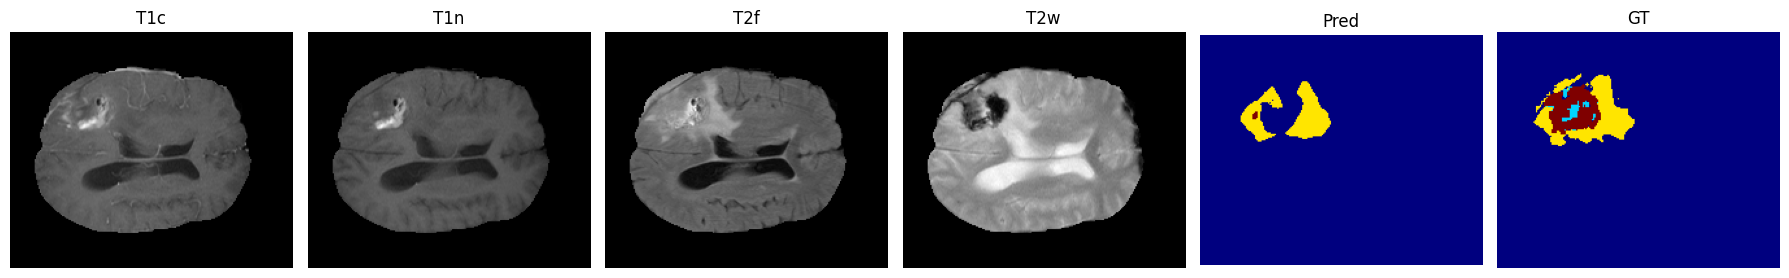

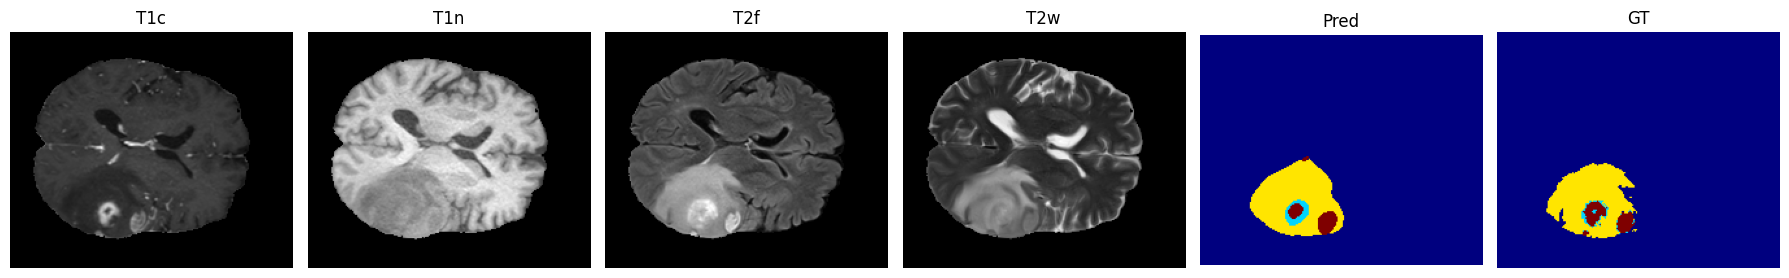

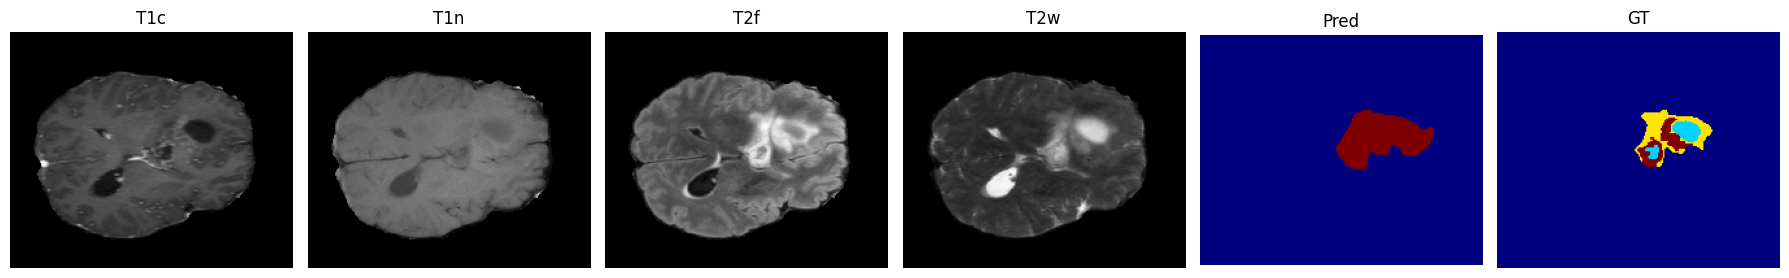

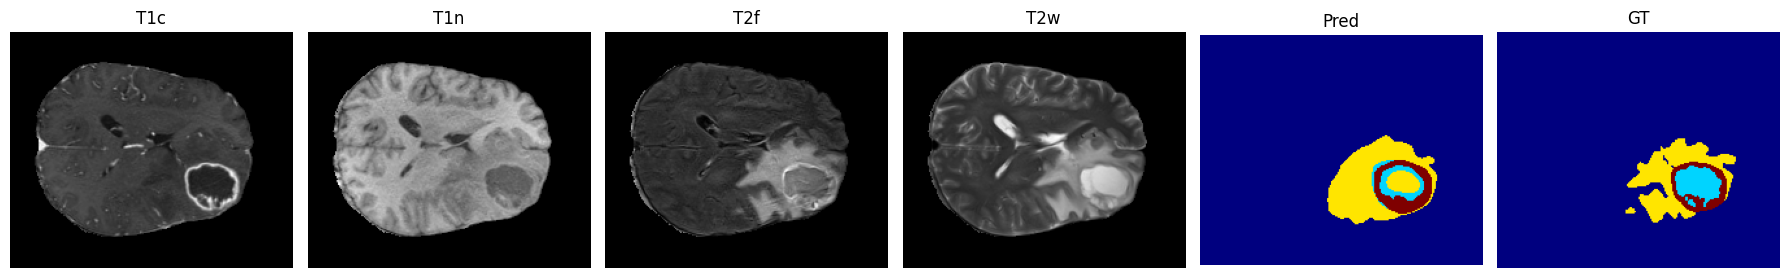

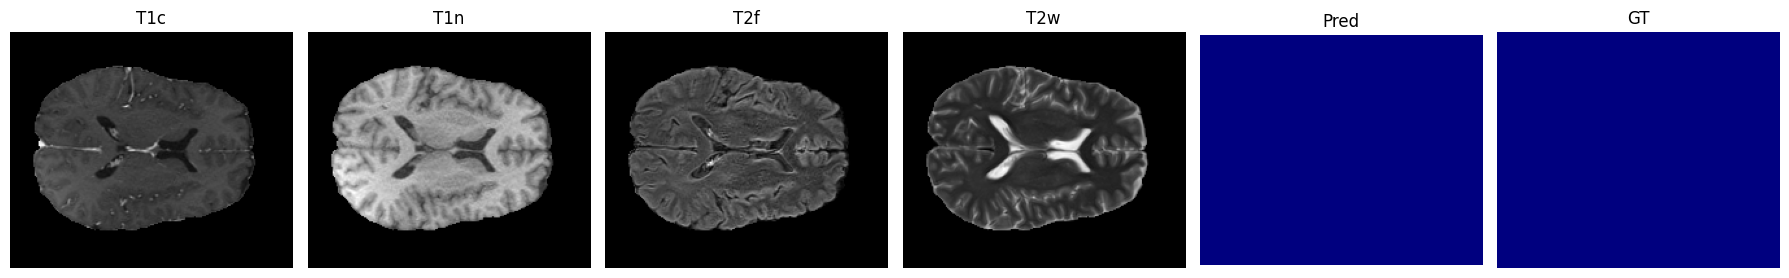

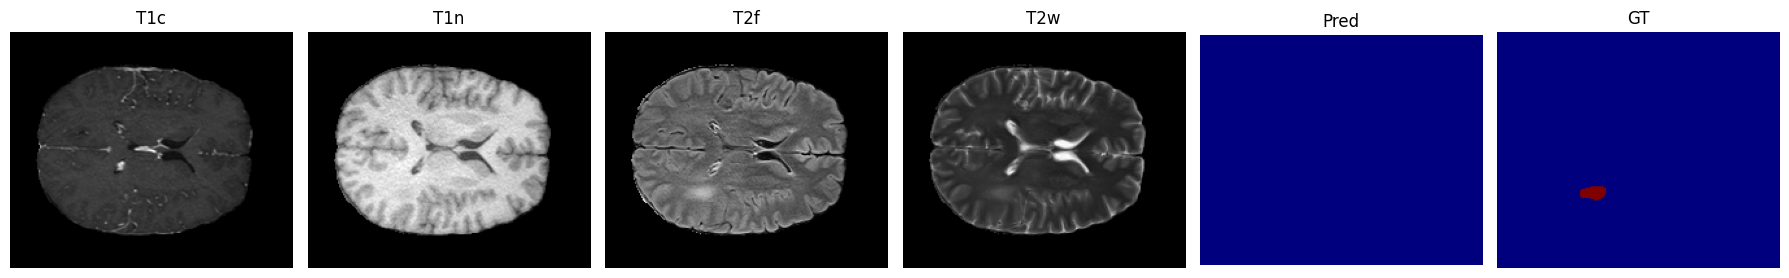

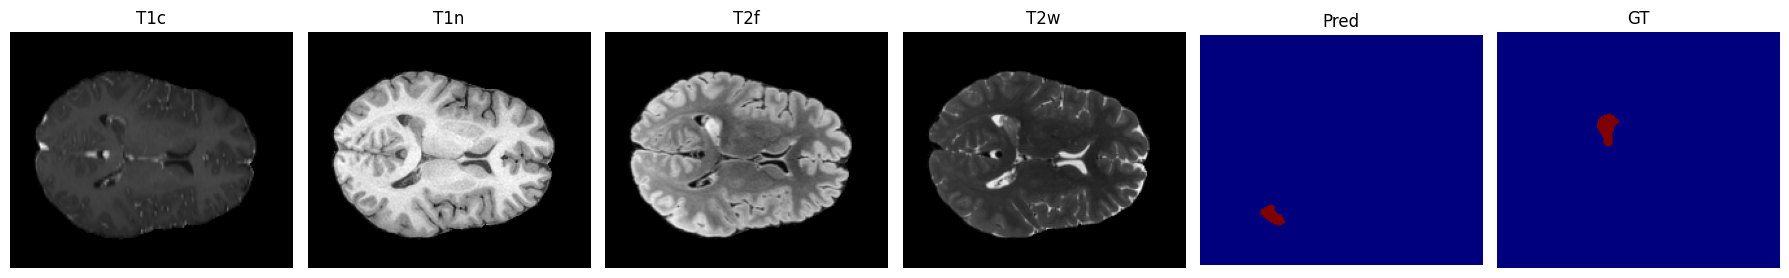

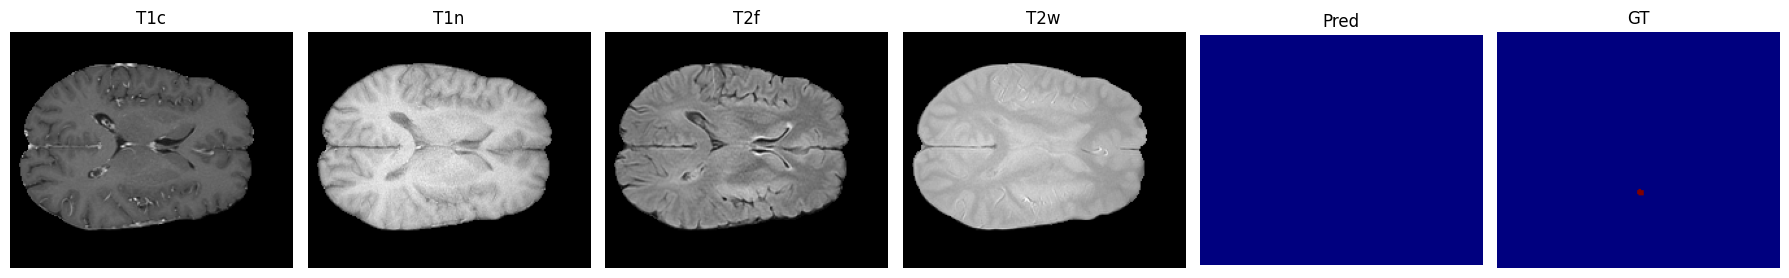

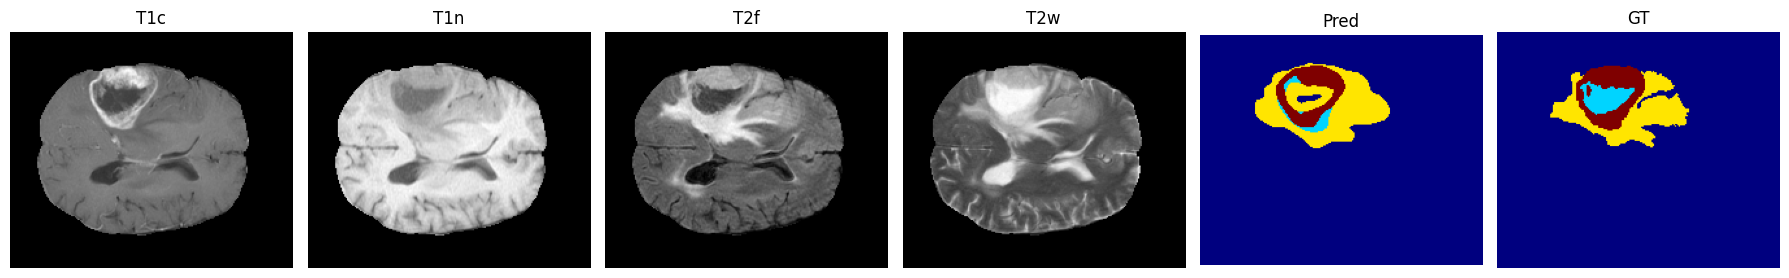

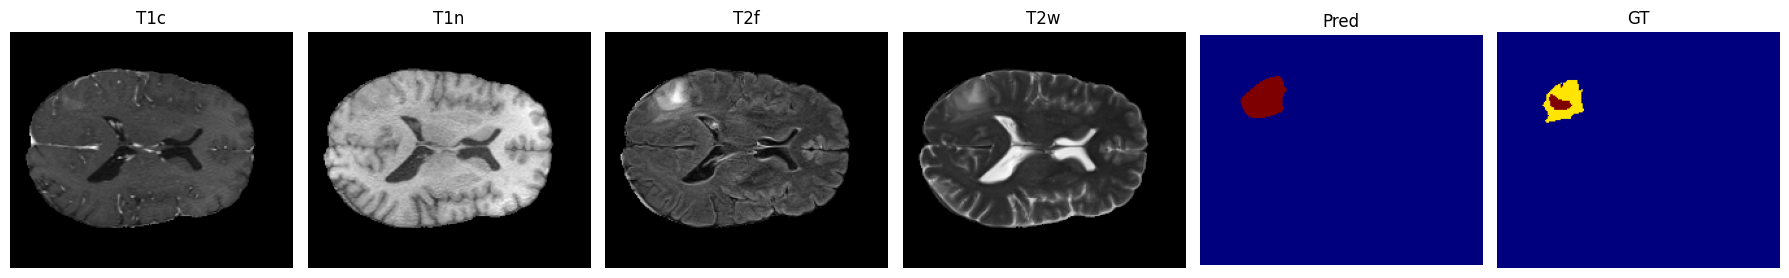

In [ ]:
import matplotlib.pyplot as plt
import random

# Visualize 6 panels in one row: 4 modalities + prediction + ground truth
for idx in random.sample(range(len(test_dataset)), 10):
    sample = test_dataset[idx]
    img = sample["image"]    # (4,128,128,128)
    gt  = sample["label"]    # (128,128,128)
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(dim=1)[0].cpu()
    sl = img.shape[3] // 2   # middle depth slice

    # Prepare a row of 6 axes
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))
    titles = ["T1c", "T1n", "T2f", "T2w", "Pred", "GT"]
    images = [
        img[0, :, :, sl].numpy(),
        img[1, :, :, sl].numpy(),
        img[2, :, :, sl].numpy(),
        img[3, :, :, sl].numpy(),
        pred[:, :, sl].numpy(),
        gt[:, :, sl].numpy()
    ]
    cmaps = ["gray", "gray", "gray", "gray", "jet", "jet"]

    for ax, im, title, cmap in zip(axes, images, titles, cmaps):
        ax.imshow(im, cmap=cmap)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
